# 필요한 라이브러리 import

In [251]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow as tf
warnings.filterwarnings(action='ignore')

# 데이터로드

In [2]:
fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

In [3]:
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)

In [4]:
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

In [5]:
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
defender_df = fm_data_df[fm_data_df['포지션']=='수비수']

# 포지션 별 EDA

## 공격수

In [6]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

### 이상치 확인

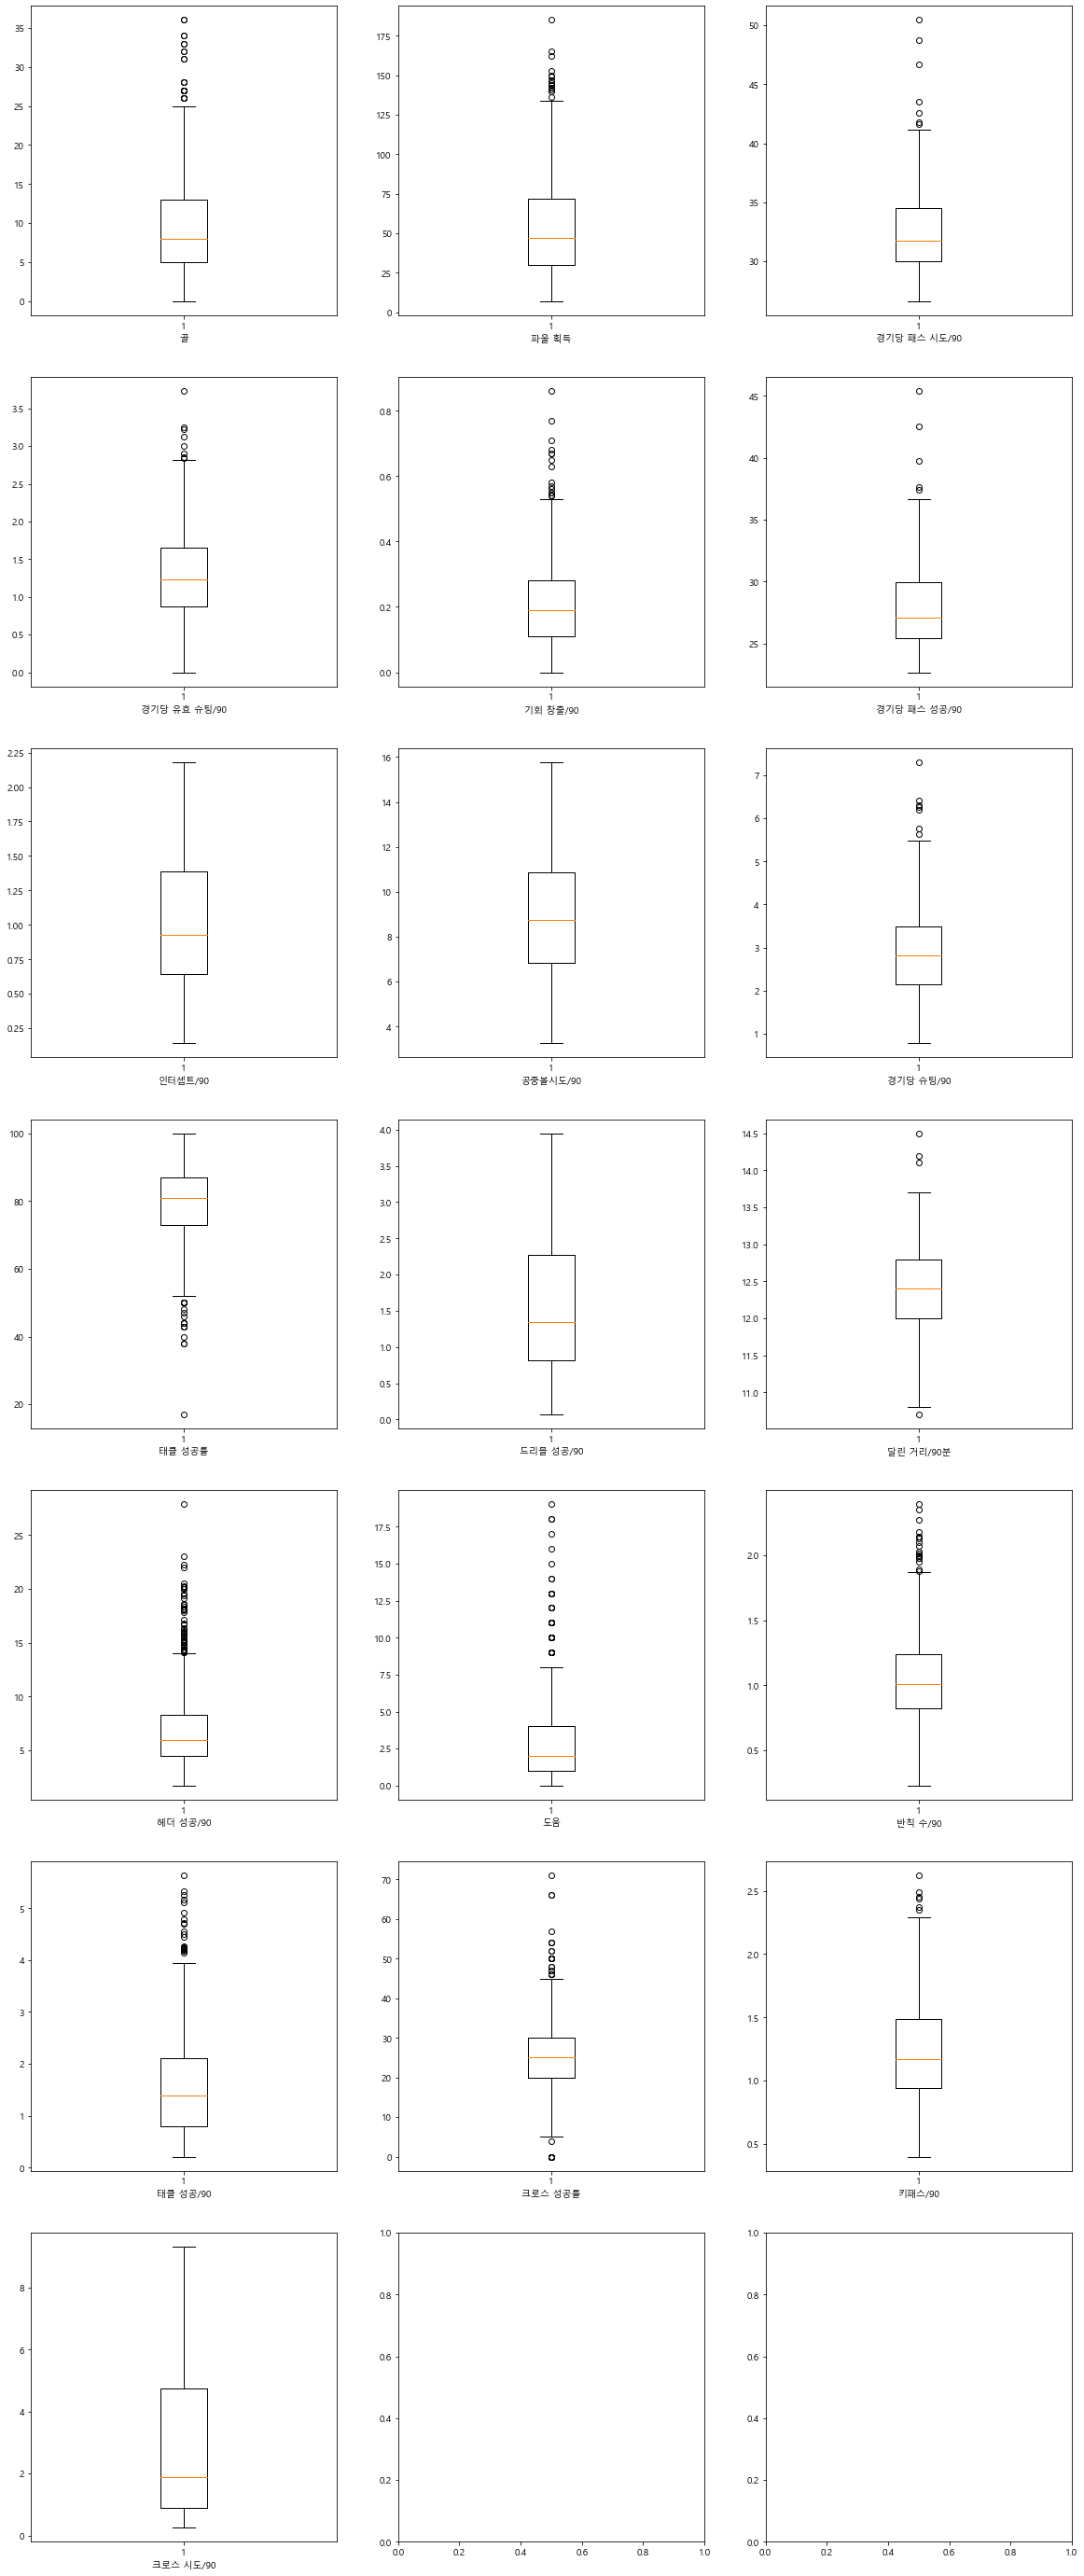

In [7]:
fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature])
    
plt.show()

In [8]:
# 데이터 당 이상치의 비율을 구하기

out_ratio = defaultdict(float)

for feature in features:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = len(data[data>high_bound]) + len(data[data>=high_bound])/ len(data)

outlier_features = [k for k,v in out_ratio.items() if v > 0.0]
nonoutlier_features = list(set(features) - set(outlier_features))

outlier_features

['골',
 '파울 획득',
 '경기당 패스 시도/90',
 '경기당 유효 슈팅/90',
 '기회 창출/90',
 '경기당 패스 성공/90',
 '경기당 슈팅/90',
 '드리블 성공/90',
 '달린 거리/90분',
 '헤더 성공/90',
 '도움',
 '반칙 수/90',
 '태클 성공/90',
 '크로스 성공률',
 '키패스/90',
 '크로스 시도/90']

### 선형성 검정

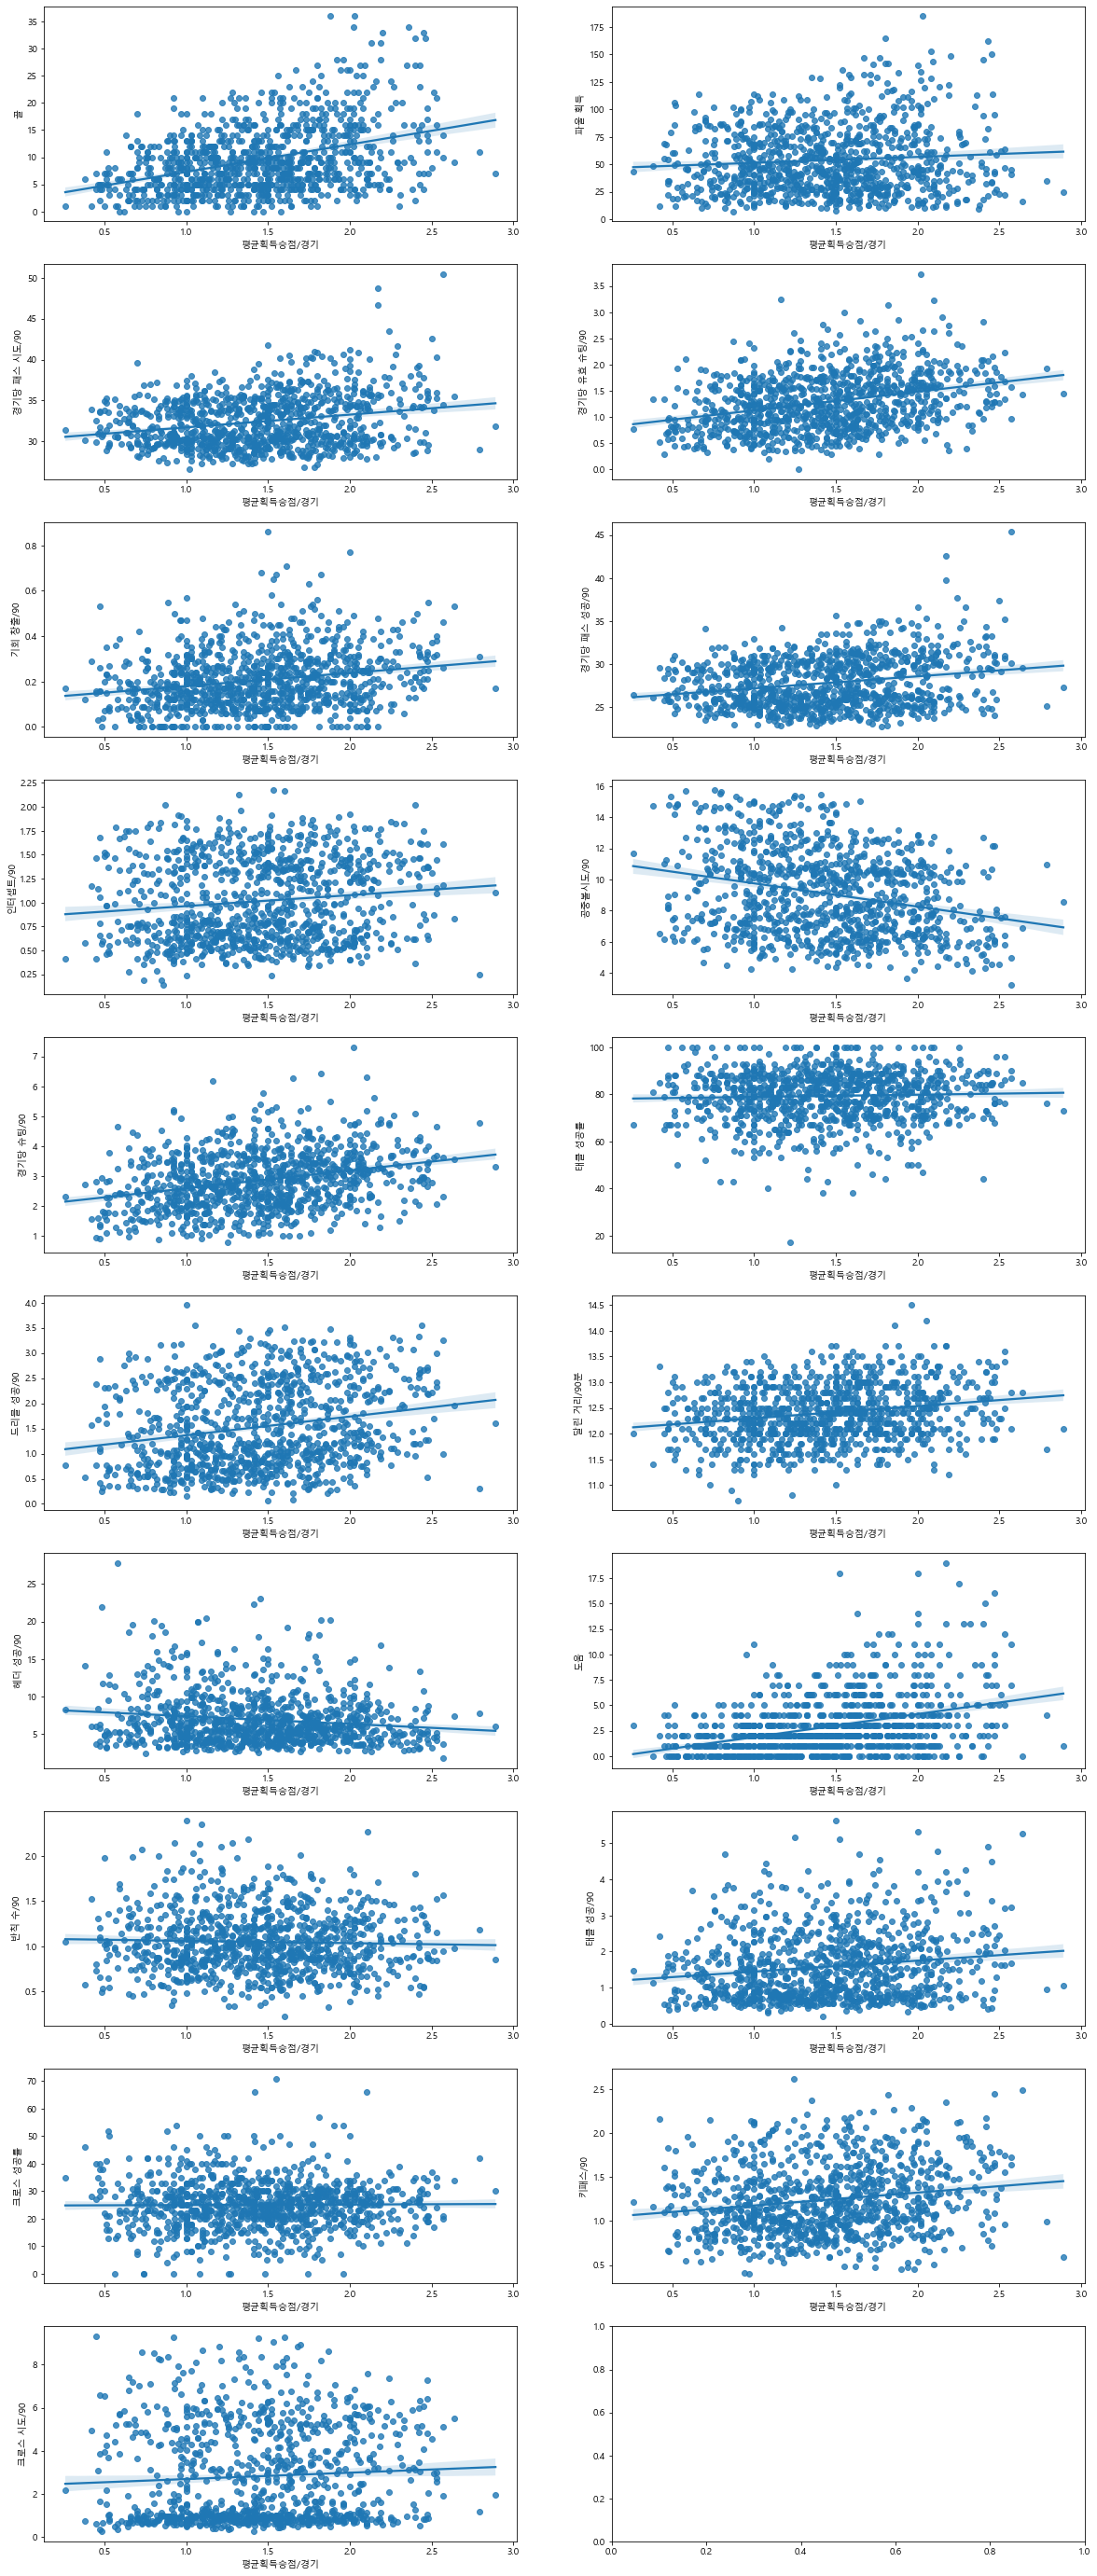

In [9]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [10]:
corr = [np.corrcoef(x ,y=forward_df.loc[:,target].T.values)[0][1] for x in forward_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('크로스 성공률', 0.01034149433563985),
 ('반칙 수/90', -0.03516430428187815),
 ('헤더 성공/90', -0.14336317747602786),
 ('공중볼시도/90', -0.2635664616800462)]

### 정규성 검정

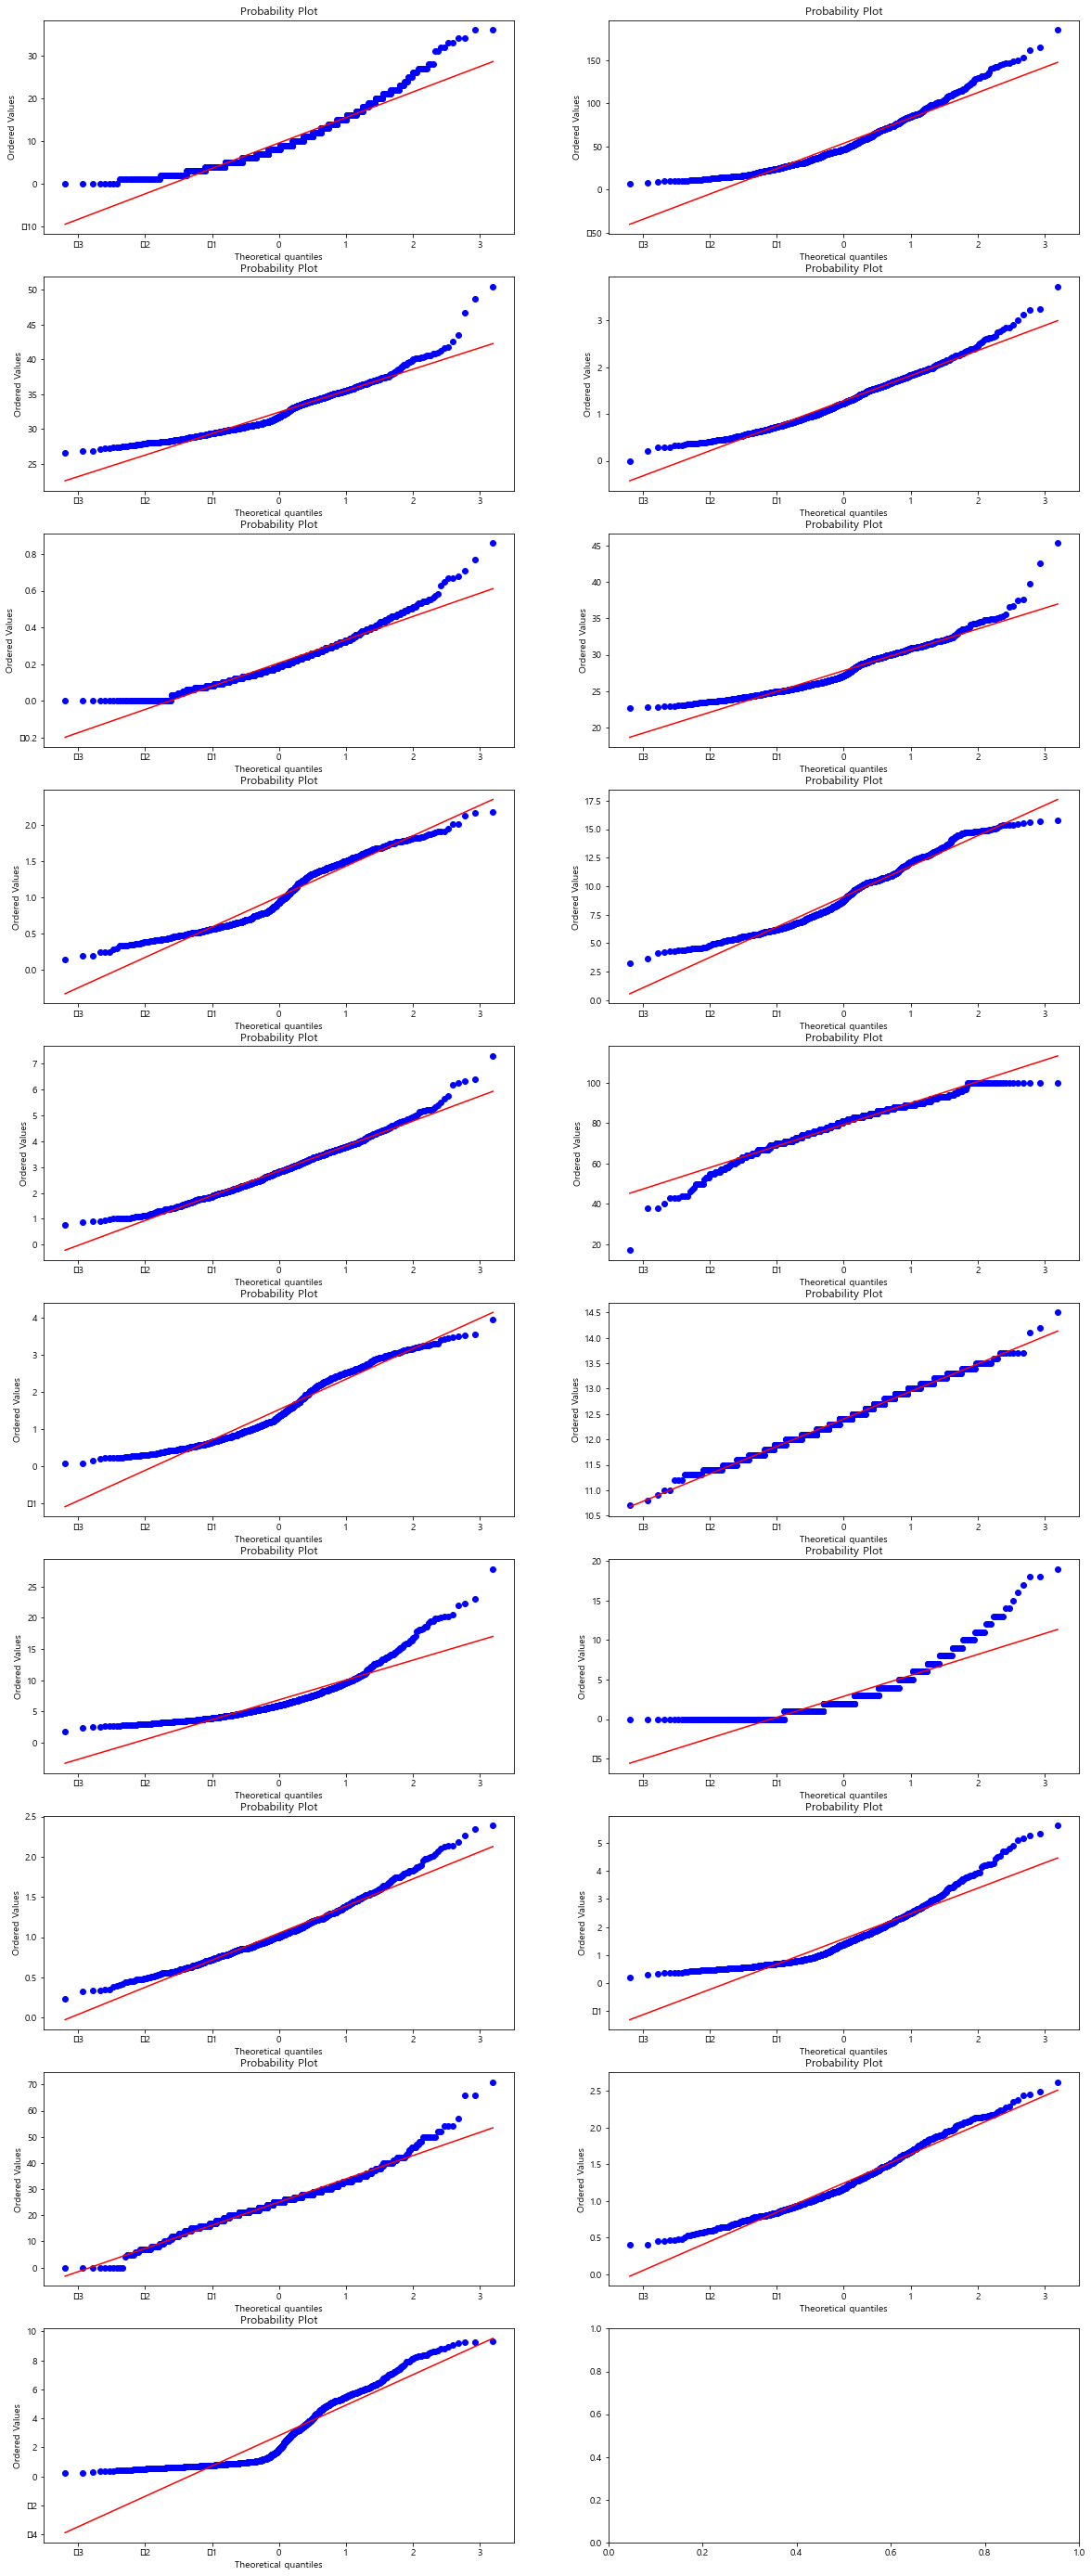

In [11]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    stats.probplot(forward_df.loc[:,feature],dist='norm',plot=ax)
    
plt.show()

In [12]:
shapiro_dict = {}

for feature in features:
    shapiro_dict[feature] = stats.shapiro(forward_df.loc[:,feature])
      
for k,v in shapiro_dict.items():
    if v[1] > 0.05:
        print(f'{k} 은/는 정규성을 만족한다. {v[1]} \n',)
        
    else:
        print(f'{k} 은/는 정규성을 만족하지 않는다.  {v[1]} \n')

골 은/는 정규성을 만족하지 않는다.  9.412561093610319e-22 

파울 획득 은/는 정규성을 만족하지 않는다.  1.977547540519971e-19 

경기당 패스 시도/90 은/는 정규성을 만족하지 않는다.  7.358035729467315e-19 

경기당 유효 슈팅/90 은/는 정규성을 만족하지 않는다.  4.7671561143047825e-11 

기회 창출/90 은/는 정규성을 만족하지 않는다.  9.418115665384223e-17 

경기당 패스 성공/90 은/는 정규성을 만족하지 않는다.  2.412282004970018e-18 

인터셉트/90 은/는 정규성을 만족하지 않는다.  3.53519002626841e-18 

공중볼시도/90 은/는 정규성을 만족하지 않는다.  1.5354534863617347e-13 

경기당 슈팅/90 은/는 정규성을 만족하지 않는다.  1.4326889008486887e-08 

태클 성공률 은/는 정규성을 만족하지 않는다.  5.166333889693045e-15 

드리블 성공/90 은/는 정규성을 만족하지 않는다.  6.292405105902122e-18 

달린 거리/90분 은/는 정규성을 만족하지 않는다.  0.0004882311914116144 

헤더 성공/90 은/는 정규성을 만족하지 않는다.  1.4181624265947407e-29 

도움 은/는 정규성을 만족하지 않는다.  5.289200778417567e-31 

반칙 수/90 은/는 정규성을 만족하지 않는다.  5.135736020484005e-12 

태클 성공/90 은/는 정규성을 만족하지 않는다.  2.6788884093050553e-24 

크로스 성공률 은/는 정규성을 만족하지 않는다.  2.693583854226911e-12 

키패스/90 은/는 정규성을 만족하지 않는다.  1.5237267827691858e-12 

크로스 시도/90 은/는 정규성을 만족하지 않는다.  2.9994252397954525e

### 등분산성 검정

In [13]:
stats.levene(*tuple([ tuple(x) for x in forward_df.loc[:,features].values]))

LeveneResult(statistic=0.12949759009581574, pvalue=0.9999999999999999)

### 독립성 확인

In [14]:
forward_df.loc[:,features].values.shape[1]

19

### 다중 공선성 확인

In [15]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(forward_df.loc[:,features].values,i) for i in range(forward_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = forward_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,3.788092,도움
1,4.842201,기회 창출/90
2,9.795654,크로스 성공률
3,9.811395,크로스 시도/90
4,12.446589,반칙 수/90
5,12.987407,골
6,13.549914,태클 성공/90
7,15.434996,파울 획득
8,18.562202,헤더 성공/90
9,21.472031,드리블 성공/90


### 변수 정규화 및 변수 선택

#### 변수 정규화

In [16]:
forward_df.loc[:,outlier_features] = QuantileTransformer(n_quantiles=1000,output_distribution='normal').fit_transform(forward_df.loc[:,outlier_features])
forward_df.loc[:,nonoutlier_features] = StandardScaler().fit_transform(forward_df.loc[:,nonoutlier_features])

#### 상관계수와 시각화를 통한 변수 선택

In [17]:
feature_comb = list(combinations(features,2))

In [18]:
corr_dict_after_norm = {}

for a,b in feature_comb:
    corr_dict_after_norm[f'{a}/{b}'] = np.corrcoef(forward_df.loc[:,a],forward_df.loc[:,b])[0][1]

In [ ]:
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = forward_df.loc[:,feature[0]], y= forward_df.loc[:,feature[1]],ax=ax)

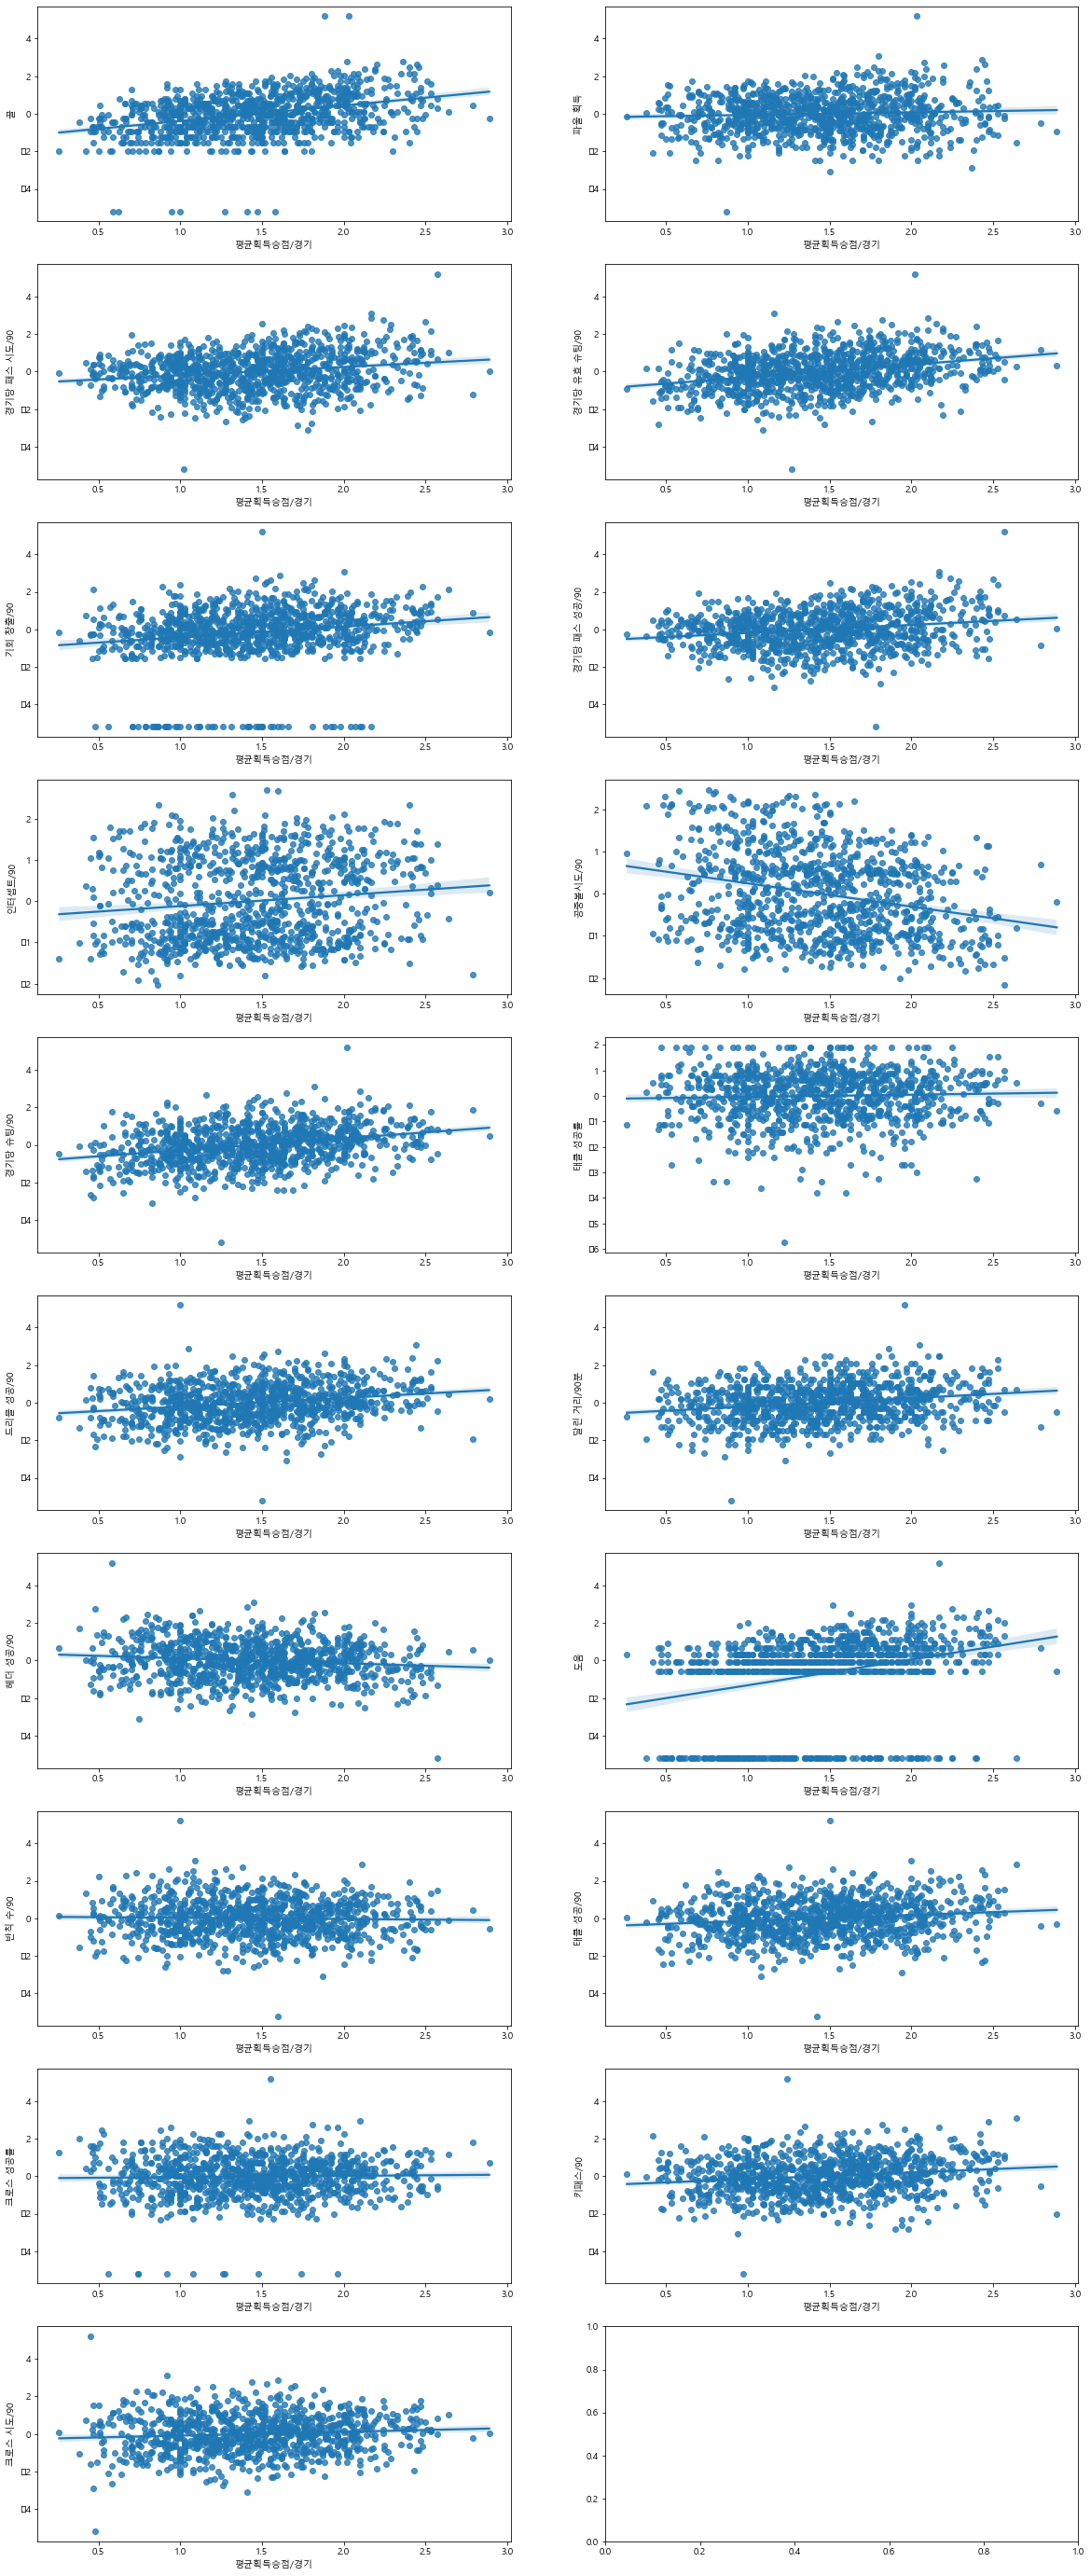

In [19]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(forward_df.loc[:,target],forward_df.loc[:,feature],ax=ax)
    
plt.show()

In [20]:
sorted(corr_dict.items(),key=lambda x:x[1],reverse=True)

[('골', 0.3899925372047754),
 ('도움', 0.3727750769369584),
 ('경기당 유효 슈팅/90', 0.3149008868945989),
 ('경기당 슈팅/90', 0.2943168941980925),
 ('경기당 패스 시도/90', 0.23483275556330324),
 ('경기당 패스 성공/90', 0.22567263258441708),
 ('기회 창출/90', 0.21355111596989557),
 ('드리블 성공/90', 0.21124806922396683),
 ('달린 거리/90분', 0.20850002371280105),
 ('키패스/90', 0.17434639122051926),
 ('태클 성공/90', 0.1533561266754542),
 ('인터셉트/90', 0.12639405293658518),
 ('파울 획득', 0.08483611536148467),
 ('크로스 시도/90', 0.06285626018412958),
 ('태클 성공률', 0.04108875139565955),
 ('크로스 성공률', 0.01034149433563985),
 ('반칙 수/90', -0.03516430428187815),
 ('헤더 성공/90', -0.14336317747602786),
 ('공중볼시도/90', -0.2635664616800462)]

In [222]:
# 상관계수가 높은 변수

# 제거할 피쳐 

good_feature_order = ['골','도움','기회 창출/90','드리블 성공/90','키패스/90','크로스 시도/90','크로스 성공률',
                      '헤더 성공/90','공중볼시도/90','경기당 유효 슈팅/90','경기당 패스 성공/90','파울 획득',
                      '달린 거리/90분','경기당 슈팅/90','경기당 패스 시도/90','태클 성공/90','인터셉트/90','파울 획득','태클 성공률','반칙 수/90']

forward_mae = []
forward_model = []

for i in range(1,len(good_feature_order)+1):
    fx_train,fx_test,fy_train,fy_test = train_test_split(forward_df.loc[:,good_feature_order[:i]],forward_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(128,activation='relu')(inputs_layer)
    hidden2 = Dense(64,activation='relu')(hidden1)
    hidden3 = Dense(32,activation='relu')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
    model.fit(fx_train,fy_train,batch_size=32,epochs=400,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    forward_mae.append(mae)
    forward_model.append(model)
    

Epoch 1/400
25/25 [==============================] - 0s 8ms/step - loss: 1.2326 - val_loss: 0.8281
Epoch 2/400
25/25 [==============================] - 0s 5ms/step - loss: 0.5000 - val_loss: 0.4780
Epoch 3/400
25/25 [==============================] - 0s 4ms/step - loss: 0.2601 - val_loss: 0.2750
Epoch 4/400
25/25 [==============================] - 0s 3ms/step - loss: 0.2027 - val_loss: 0.2276
Epoch 5/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1949 - val_loss: 0.2578
Epoch 6/400
25/25 [==============================] - ETA: 0s - loss: 0.196 - 0s 4ms/step - loss: 0.1929 - val_loss: 0.2431
Epoch 7/400
25/25 [==============================] - 0s 5ms/step - loss: 0.1915 - val_loss: 0.2466
Epoch 8/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1935 - val_loss: 0.2438
Epoch 9/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1969 - val_loss: 0.2403
Epoch 10/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1906 - va

25/25 [==============================] - 0s 3ms/step - loss: 0.1906 - val_loss: 0.2457
Epoch 83/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1918 - val_loss: 0.2355
Epoch 84/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1895 - val_loss: 0.2402
Epoch 85/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1930 - val_loss: 0.2258
Epoch 86/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1887 - val_loss: 0.2356
Epoch 87/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1903 - val_loss: 0.2343
Epoch 88/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1897 - val_loss: 0.2376
Epoch 89/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1893 - val_loss: 0.2387
Epoch 90/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1891 - val_loss: 0.2238
Epoch 91/400
25/25 [==============================] - 0s 3ms/step - loss: 0.1916 - val_loss: 0.2347
Epoch 92/400


KeyboardInterrupt: 

In [69]:
forward_mae

[0.3384691925723143,
 0.357449978674301,
 0.4011372727577132,
 0.4133405462419144,
 0.4380431095036593,
 0.44506483223703175,
 0.42082638763418106,
 0.36890079412797483,
 0.3581886059587652,
 0.328624480637637,
 0.33361307657728295,
 0.3405689285861121,
 0.3679081921023552,
 0.3681297738624342,
 0.3152344007564314,
 0.3033455652781207,
 0.31885070545504796,
 0.3599503319552451,
 0.34667099015881314,
 0.3136379011833307]

In [100]:
plt.close()

In [98]:
forward_mae_dict = {}

for i,mae in enumerate(forward_mae):
    forward_mae_dict[i+1] = mae

20

In [104]:
mae_df = pd.DataFrame.from_dict(forward_mae_dict,orient='index')

In [116]:
mae_df.columns = ['MAE']
mae_df.reset_index(inplace=True)
mae_df

,index,MAE
0,1,0.338469
1,2,0.357450
2,3,0.401137
3,4,0.413341
4,5,0.438043
5,6,0.445065
6,7,0.420826
7,8,0.368901
8,9,0.358189
9,10,0.328624


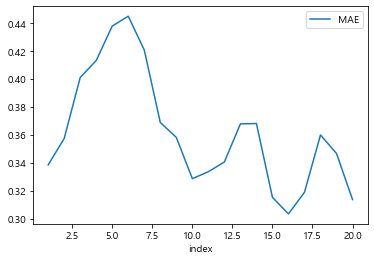

In [205]:
mae_df.plot.line(x='index',y='MAE')
plt.show()

In [252]:
good_features = good_feature_order[:10]
good_features

['골',
 '도움',
 '기회 창출/90',
 '드리블 성공/90',
 '키패스/90',
 '크로스 시도/90',
 '크로스 성공률',
 '헤더 성공/90',
 '공중볼시도/90',
 '경기당 유효 슈팅/90']

In [250]:
fx_train,fx_test,fy_train,fy_test = train_test_split(forward_df.loc[:,good_features],forward_df.loc[:,target],test_size=0.2)
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(512,activation='relu',kernel_regularizer=L2(l2=0.01))(inputs_layer)
hidden2 = Dense(128,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dropout(0.3)(hidden2)
hidden4 = Dense(64,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(32,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden4)
hidden6 = Dense(16,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden5)
hidden7 = Dense(8,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden6)
output = Dense(1,activation='linear')(hidden7)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=70,epochs=2000,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)

model.save('./models/forward_nn.h5')

Epoch 1/2000
12/12 [==============================] - 1s 20ms/step - loss: 4.6655 - val_loss: 3.8634
Epoch 2/2000
12/12 [==============================] - 0s 9ms/step - loss: 3.7272 - val_loss: 3.3787
Epoch 3/2000
12/12 [==============================] - 0s 9ms/step - loss: 3.2450 - val_loss: 2.9540
Epoch 4/2000
12/12 [==============================] - 0s 10ms/step - loss: 2.8471 - val_loss: 2.5716
Epoch 5/2000
12/12 [==============================] - 0s 8ms/step - loss: 2.4876 - val_loss: 2.2595
Epoch 6/2000
12/12 [==============================] - 0s 9ms/step - loss: 2.1717 - val_loss: 2.0021
Epoch 7/2000
12/12 [==============================] - 0s 8ms/step - loss: 1.9224 - val_loss: 1.7573
Epoch 8/2000
12/12 [==============================] - 0s 9ms/step - loss: 1.6990 - val_loss: 1.5653
Epoch 9/2000
12/12 [==============================] - 0s 9ms/step - loss: 1.5125 - val_loss: 1.4003
Epoch 10/2000
12/12 [==============================] - 0s 8ms/step - loss: 1.3620 - val_loss: 1.26

12/12 [==============================] - 0s 8ms/step - loss: 0.1887 - val_loss: 0.1819
Epoch 83/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1870 - val_loss: 0.1823
Epoch 84/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1875 - val_loss: 0.1842
Epoch 85/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1862 - val_loss: 0.1816
Epoch 86/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1873 - val_loss: 0.1812
Epoch 87/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1870 - val_loss: 0.1787
Epoch 88/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1849 - val_loss: 0.1818
Epoch 89/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1854 - val_loss: 0.1798
Epoch 90/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1873 - val_loss: 0.1827
Epoch 91/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1822 - val_loss: 0.1778
Epoc

12/12 [==============================] - 0s 8ms/step - loss: 0.1671 - val_loss: 0.1619
Epoch 163/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1669 - val_loss: 0.1680
Epoch 164/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1697 - val_loss: 0.1646
Epoch 165/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1666 - val_loss: 0.1634
Epoch 166/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1689 - val_loss: 0.1633
Epoch 167/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1676 - val_loss: 0.1678
Epoch 168/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1676 - val_loss: 0.1624
Epoch 169/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1673 - val_loss: 0.1652
Epoch 170/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1643 - val_loss: 0.1634
Epoch 171/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1655 - val_loss: 0.

12/12 [==============================] - 0s 9ms/step - loss: 0.1638 - val_loss: 0.1611
Epoch 243/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1633 - val_loss: 0.1591
Epoch 244/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1655 - val_loss: 0.1576
Epoch 245/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1638 - val_loss: 0.1581
Epoch 246/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1619 - val_loss: 0.1607
Epoch 247/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1645 - val_loss: 0.1570
Epoch 248/2000
12/12 [==============================] - 0s 11ms/step - loss: 0.1637 - val_loss: 0.1598
Epoch 249/2000
12/12 [==============================] - 0s 10ms/step - loss: 0.1616 - val_loss: 0.1601
Epoch 250/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1632 - val_loss: 0.1577
Epoch 251/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1620 - val_loss: 

12/12 [==============================] - 0s 8ms/step - loss: 0.1593 - val_loss: 0.1558
Epoch 323/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1607 - val_loss: 0.1578
Epoch 324/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1600 - val_loss: 0.1655
Epoch 325/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1607 - val_loss: 0.1668
Epoch 326/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1647 - val_loss: 0.1557
Epoch 327/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1598 - val_loss: 0.1658
Epoch 328/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1609 - val_loss: 0.1612
Epoch 329/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1634 - val_loss: 0.1609
Epoch 330/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1596 - val_loss: 0.1559
Epoch 331/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1625 - val_loss: 0.

12/12 [==============================] - 0s 8ms/step - loss: 0.1584 - val_loss: 0.1548
Epoch 403/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1592 - val_loss: 0.1644
Epoch 404/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1659 - val_loss: 0.1590
Epoch 405/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1589 - val_loss: 0.1559
Epoch 406/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1614 - val_loss: 0.1546
Epoch 407/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1589 - val_loss: 0.1585
Epoch 408/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1600 - val_loss: 0.1605
Epoch 409/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1590 - val_loss: 0.1550
Epoch 410/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1591 - val_loss: 0.1630
Epoch 411/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1606 - val_loss: 0.

12/12 [==============================] - 0s 8ms/step - loss: 0.1608 - val_loss: 0.1546
Epoch 483/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1606 - val_loss: 0.1641
Epoch 484/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1574 - val_loss: 0.1597
Epoch 485/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1580 - val_loss: 0.1558
Epoch 486/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1605 - val_loss: 0.1544
Epoch 487/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1631 - val_loss: 0.1553
Epoch 488/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1596 - val_loss: 0.1574
Epoch 489/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1585 - val_loss: 0.1587
Epoch 490/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1573 - val_loss: 0.1558
Epoch 491/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1575 - val_loss: 0.

12/12 [==============================] - 0s 7ms/step - loss: 0.1550 - val_loss: 0.1637
Epoch 563/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1583 - val_loss: 0.1546
Epoch 564/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1586 - val_loss: 0.1538
Epoch 565/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1566 - val_loss: 0.1567
Epoch 566/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1572 - val_loss: 0.1624
Epoch 567/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1547 - val_loss: 0.1531
Epoch 568/2000
12/12 [==============================] - 0s 6ms/step - loss: 0.1564 - val_loss: 0.1573
Epoch 569/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1568 - val_loss: 0.1541
Epoch 570/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1576 - val_loss: 0.1536
Epoch 571/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1577 - val_loss: 0.

12/12 [==============================] - 0s 7ms/step - loss: 0.1553 - val_loss: 0.1567
Epoch 643/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1570 - val_loss: 0.1535
Epoch 644/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1590 - val_loss: 0.1534
Epoch 645/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1557 - val_loss: 0.1559
Epoch 646/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1552 - val_loss: 0.1707
Epoch 647/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1571 - val_loss: 0.1543
Epoch 648/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1552 - val_loss: 0.1555
Epoch 649/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1593 - val_loss: 0.1649
Epoch 650/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1577 - val_loss: 0.1522
Epoch 651/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1576 - val_loss: 0.

12/12 [==============================] - 0s 7ms/step - loss: 0.1551 - val_loss: 0.1556
Epoch 723/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1579 - val_loss: 0.1605
Epoch 724/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1546 - val_loss: 0.1547
Epoch 725/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1577 - val_loss: 0.1579
Epoch 726/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1550 - val_loss: 0.1536
Epoch 727/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1566 - val_loss: 0.1541
Epoch 728/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1561 - val_loss: 0.1541
Epoch 729/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1549 - val_loss: 0.1532
Epoch 730/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1536 - val_loss: 0.1590
Epoch 731/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1549 - val_loss: 0.

12/12 [==============================] - 0s 7ms/step - loss: 0.1529 - val_loss: 0.1550
Epoch 803/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1544 - val_loss: 0.1571
Epoch 804/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1523 - val_loss: 0.1519
Epoch 805/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1522 - val_loss: 0.1561
Epoch 806/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1554 - val_loss: 0.1580
Epoch 807/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1547 - val_loss: 0.1554
Epoch 808/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1531 - val_loss: 0.1518
Epoch 809/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1544 - val_loss: 0.1538
Epoch 810/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1541 - val_loss: 0.1524
Epoch 811/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1550 - val_loss: 0.

12/12 [==============================] - 0s 8ms/step - loss: 0.1539 - val_loss: 0.1557
Epoch 883/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1551 - val_loss: 0.1518
Epoch 884/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1532 - val_loss: 0.1523
Epoch 885/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1565 - val_loss: 0.1608
Epoch 886/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1526 - val_loss: 0.1509
Epoch 887/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1519 - val_loss: 0.1530
Epoch 888/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1531 - val_loss: 0.1530
Epoch 889/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1532 - val_loss: 0.1583
Epoch 890/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1498 - val_loss: 0.1517
Epoch 891/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1517 - val_loss: 0.

12/12 [==============================] - 0s 7ms/step - loss: 0.1516 - val_loss: 0.1528
Epoch 963/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1531 - val_loss: 0.1547
Epoch 964/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1506 - val_loss: 0.1566
Epoch 965/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1551 - val_loss: 0.1538
Epoch 966/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1524 - val_loss: 0.1519
Epoch 967/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1549 - val_loss: 0.1507
Epoch 968/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1549 - val_loss: 0.1519
Epoch 969/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1515 - val_loss: 0.1584
Epoch 970/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1506 - val_loss: 0.1502
Epoch 971/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1535 - val_loss: 0.

12/12 [==============================] - 0s 8ms/step - loss: 0.1517 - val_loss: 0.1505
Epoch 1043/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1524 - val_loss: 0.1530
Epoch 1044/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1518 - val_loss: 0.1569
Epoch 1045/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1519 - val_loss: 0.1511
Epoch 1046/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1537 - val_loss: 0.1527
Epoch 1047/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1512 - val_loss: 0.1555
Epoch 1048/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1517 - val_loss: 0.1510
Epoch 1049/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1510 - val_loss: 0.1502
Epoch 1050/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1541 - val_loss: 0.1535
Epoch 1051/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1502 - val

12/12 [==============================] - 0s 9ms/step - loss: 0.1488 - val_loss: 0.1550
Epoch 1122/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1499 - val_loss: 0.1511
Epoch 1123/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1496 - val_loss: 0.1512
Epoch 1124/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1535 - val_loss: 0.1611
Epoch 1125/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1535 - val_loss: 0.1524
Epoch 1126/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1502 - val_loss: 0.1506
Epoch 1127/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1497 - val_loss: 0.1526
Epoch 1128/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1488 - val_loss: 0.1503
Epoch 1129/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1503 - val_loss: 0.1535
Epoch 1130/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1484 - val

12/12 [==============================] - 0s 8ms/step - loss: 0.1498 - val_loss: 0.1538
Epoch 1201/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1518 - val_loss: 0.1675
Epoch 1202/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1549 - val_loss: 0.1509
Epoch 1203/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1513 - val_loss: 0.1505
Epoch 1204/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1509 - val_loss: 0.1511
Epoch 1205/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1492 - val_loss: 0.1494
Epoch 1206/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1505 - val_loss: 0.1502
Epoch 1207/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1497 - val_loss: 0.1495
Epoch 1208/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1502 - val_loss: 0.1520
Epoch 1209/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1507 - val

12/12 [==============================] - 0s 9ms/step - loss: 0.1552 - val_loss: 0.1550
Epoch 1280/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1534 - val_loss: 0.1777
Epoch 1281/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1594 - val_loss: 0.1519
Epoch 1282/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1491 - val_loss: 0.1505
Epoch 1283/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1510 - val_loss: 0.1625
Epoch 1284/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1533 - val_loss: 0.1608
Epoch 1285/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1505 - val_loss: 0.1486
Epoch 1286/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1480 - val_loss: 0.1529
Epoch 1287/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1479 - val_loss: 0.1551
Epoch 1288/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1476 - val

12/12 [==============================] - 0s 8ms/step - loss: 0.1520 - val_loss: 0.1489
Epoch 1359/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1487 - val_loss: 0.1497
Epoch 1360/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1475 - val_loss: 0.1515
Epoch 1361/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1473 - val_loss: 0.1516
Epoch 1362/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1506 - val_loss: 0.1506
Epoch 1363/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1526 - val_loss: 0.1685
Epoch 1364/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1504 - val_loss: 0.1476
Epoch 1365/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1489 - val_loss: 0.1505
Epoch 1366/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1488 - val_loss: 0.1530
Epoch 1367/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1474 - val

12/12 [==============================] - 0s 10ms/step - loss: 0.1476 - val_loss: 0.1615
Epoch 1438/2000
12/12 [==============================] - 0s 10ms/step - loss: 0.1497 - val_loss: 0.1535
Epoch 1439/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1485 - val_loss: 0.1479
Epoch 1440/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1490 - val_loss: 0.1488
Epoch 1441/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1459 - val_loss: 0.1520
Epoch 1442/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1469 - val_loss: 0.1512
Epoch 1443/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1464 - val_loss: 0.1534
Epoch 1444/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1476 - val_loss: 0.1565
Epoch 1445/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1455 - val_loss: 0.1508
Epoch 1446/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1469 - v

12/12 [==============================] - 0s 8ms/step - loss: 0.1510 - val_loss: 0.1509
Epoch 1517/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1484 - val_loss: 0.1569
Epoch 1518/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1475 - val_loss: 0.1504
Epoch 1519/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1478 - val_loss: 0.1494
Epoch 1520/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1479 - val_loss: 0.1516
Epoch 1521/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1480 - val_loss: 0.1556
Epoch 1522/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1468 - val_loss: 0.1487
Epoch 1523/2000
12/12 [==============================] - 0s 10ms/step - loss: 0.1471 - val_loss: 0.1481
Epoch 1524/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1473 - val_loss: 0.1585
Epoch 1525/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1465 - va

12/12 [==============================] - 0s 9ms/step - loss: 0.1447 - val_loss: 0.1472
Epoch 1596/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1446 - val_loss: 0.1476
Epoch 1597/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1493 - val_loss: 0.1532
Epoch 1598/2000
12/12 [==============================] - 0s 10ms/step - loss: 0.1447 - val_loss: 0.1514
Epoch 1599/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1472 - val_loss: 0.1524
Epoch 1600/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1495 - val_loss: 0.1485
Epoch 1601/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1481 - val_loss: 0.1490
Epoch 1602/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1449 - val_loss: 0.1497
Epoch 1603/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1481 - val_loss: 0.1465
Epoch 1604/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1511 - va

12/12 [==============================] - 0s 8ms/step - loss: 0.1469 - val_loss: 0.1609
Epoch 1675/2000
12/12 [==============================] - 0s 10ms/step - loss: 0.1463 - val_loss: 0.1537
Epoch 1676/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1444 - val_loss: 0.1503
Epoch 1677/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1479 - val_loss: 0.1490
Epoch 1678/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1451 - val_loss: 0.1480
Epoch 1679/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1475 - val_loss: 0.1502
Epoch 1680/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1456 - val_loss: 0.1501
Epoch 1681/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1437 - val_loss: 0.1487
Epoch 1682/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1433 - val_loss: 0.1491
Epoch 1683/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1446 - va

12/12 [==============================] - 0s 7ms/step - loss: 0.1467 - val_loss: 0.1486
Epoch 1754/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1451 - val_loss: 0.1469
Epoch 1755/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1446 - val_loss: 0.1538
Epoch 1756/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1450 - val_loss: 0.1498
Epoch 1757/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1438 - val_loss: 0.1478
Epoch 1758/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1453 - val_loss: 0.1464
Epoch 1759/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1468 - val_loss: 0.1539
Epoch 1760/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1444 - val_loss: 0.1484
Epoch 1761/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1465 - val_loss: 0.1518
Epoch 1762/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1432 - val

12/12 [==============================] - 0s 9ms/step - loss: 0.1434 - val_loss: 0.1505
Epoch 1833/2000
12/12 [==============================] - 0s 9ms/step - loss: 0.1462 - val_loss: 0.1535
Epoch 1834/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1451 - val_loss: 0.1504
Epoch 1835/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1447 - val_loss: 0.1479
Epoch 1836/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1434 - val_loss: 0.1488
Epoch 1837/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1440 - val_loss: 0.1509
Epoch 1838/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1431 - val_loss: 0.1483
Epoch 1839/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1456 - val_loss: 0.1460
Epoch 1840/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1463 - val_loss: 0.1469
Epoch 1841/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1430 - val

12/12 [==============================] - 0s 8ms/step - loss: 0.1441 - val_loss: 0.1444
Epoch 1912/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1493 - val_loss: 0.1469
Epoch 1913/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1439 - val_loss: 0.1496
Epoch 1914/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1431 - val_loss: 0.1477
Epoch 1915/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1453 - val_loss: 0.1517
Epoch 1916/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1438 - val_loss: 0.1486
Epoch 1917/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1431 - val_loss: 0.1563
Epoch 1918/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1439 - val_loss: 0.1461
Epoch 1919/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1471 - val_loss: 0.1463
Epoch 1920/2000
12/12 [==============================] - 0s 8ms/step - loss: 0.1445 - val

12/12 [==============================] - 0s 7ms/step - loss: 0.1457 - val_loss: 0.1463
Epoch 1991/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1428 - val_loss: 0.1485
Epoch 1992/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1462 - val_loss: 0.1470
Epoch 1993/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1436 - val_loss: 0.1472
Epoch 1994/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1447 - val_loss: 0.1492
Epoch 1995/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1435 - val_loss: 0.1469
Epoch 1996/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1465 - val_loss: 0.1448
Epoch 1997/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1465 - val_loss: 0.1466
Epoch 1998/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1439 - val_loss: 0.1579
Epoch 1999/2000
12/12 [==============================] - 0s 7ms/step - loss: 0.1475 - val

In [ ]:
def get_corr_use(df):
    
    df = df.loc[:,use_col].corr()

    this_corr = defaultdict(tuple)

    for col in df.columns:
        for index in df.index:
            if df.loc[col,index] <= -0.6:
                this_corr[tuple(set([col,index]))] = df.loc[col,index]
            elif df.loc[col,index] >= 0.6 and df.loc[col,index] < 1.0:
                this_corr[tuple(set([col,index]))] = df.loc[col,index]
            
    return this_corr

In [ ]:
forward_corr = get_corr_use(forward_df)
forward_corr

In [ ]:
midfielder_corr = get_corr_use(midfielder_df)
midfielder_corr

In [ ]:
defender_corr = get_corr_use(defender_df)
defender_corr

In [ ]:
forward_ss = StandardScaler().fit(forward_df.loc[:,use_col[:-1]])
forward_df.loc[:,use_col[:-1]] = forward_ss.transform(forward_df.loc[:,use_col[:-1]])

midfielder_ss = StandardScaler().fit(midfielder_df.loc[:,use_col[:-1]])
midfielder_df.loc[:,use_col[:-1]] = midfielder_ss.transform(midfielder_df.loc[:,use_col[:-1]])

defender_ss = StandardScaler().fit(defender_df.loc[:,use_col[:-1]])
defender_df.loc[:,use_col[:-1]] = defender_ss.transform(defender_df.loc[:,use_col[:-1]])

with open('./models/공격수_ss.pickle','wb') as f:
    pickle.dump(forward_ss,f)
    
with open('./models/미드필더_ss.pickle','wb') as f:
    pickle.dump(midfielder_ss,f)
    
with open('./models/수비수_ss.pickle','wb') as f:
    pickle.dump(defender_ss,f)

In [ ]:
forward_pca = PCA(n_components=len(use_col[:-1])).fit(forward_df.loc[:,use_col[:-1]])
forward_df.loc[:,use_col[:-1]] = forward_pca.transform(forward_df.loc[:,use_col[:-1]])


midfielder_pca = PCA(n_components=len(use_col[:-1])).fit(midfielder_df.loc[:,use_col[:-1]])
midfielder_df.loc[:,use_col[:-1]] = midfielder_pca.transform(midfielder_df.loc[:,use_col[:-1]])

defender_pca = PCA(n_components=len(use_col[:-1])).fit(defender_df.loc[:,use_col[:-1]])
defender_df.loc[:,use_col[:-1]] = defender_pca.transform(defender_df.loc[:,use_col[:-1]])


with open('./models/공격수_pca.pickle','wb') as f:
    pickle.dump(forward_pca,f)
    
with open('./models/미드필더_pca.pickle','wb') as f:
    pickle.dump(midfielder_pca,f)
    
with open('./models/수비수_pca.pickle','wb') as f:
    pickle.dump(defender_pca,f)

In [ ]:
f_train,f_test = train_test_split(forward_df.loc[:,use_col],test_size=0.3)
m_train,m_test = train_test_split(midfielder_df.loc[:,use_col],test_size=0.3)
d_train,d_test = train_test_split(defender_df.loc[:,use_col],test_size=0.3)

In [ ]:
forward_df.loc[:,use_col].info()

In [ ]:
type(forward_df.loc[:,use_col].values)

In [ ]:
def make_regressor_and_save(position,df):
    
    split_count = 5
    
    inputs_layer = Input(shape=(19,))
    hidden1 = Dense(256,activation='relu')(inputs_layer)
    hidden2 = Dense(128,activation='relu')(hidden1)
    hidden3 = Dense(64,activation='relu')(hidden2)
    hidden4 = Dense(32,activation='relu')(hidden3)
    output = Dense(1,activation='linear')(hidden4)
    
    model = Model(inputs=[inputs_layer],outputs=[output])
    
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
   
    X,Y = df.loc[:,use_col[:-1]],df.loc[:,use_col[-1]]
    
    kf = KFold(n_splits= split_count)
    kf.get_n_splits(X)
    
    ml_model_list = []
    ml_mae_score_list = []
    
    for train_index, test_index in kf.split(X):
        
        x_train, x_test = tf.constant(X.values[train_index]),tf.constant(X.values[test_index])
        y_train, y_test = tf.constant(Y.values[train_index]), tf.constant(Y.values[test_index])
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
        model.fit(x_train,y_train,batch_size=32,epochs=1000,validation_data=(x_test,y_test))
        
        predict_result=model.predict(x_test)
        mae = mean_absolute_error(y_test,predict_result)
        ml_mae_score_list.append(mae)
        ml_model_list.append(model)
        
    min_val = min(ml_mae_score_list)
    index = ml_mae_score_list.index(min_val)
    
    model.save('./models/'+position+'_nn.h5')
        
    return ml_mae_score_list[index]

In [ ]:
make_regressor_and_save('공격수',forward_df.loc[:,use_col])

In [ ]:
make_regressor_and_save('미드필더',midfielder_df.loc[:,use_col])

In [ ]:
make_regressor_and_save('수비수',defender_df.loc[:,use_col])